In [1]:
import os
import sys
import json
import pandas as pd
import numpy as np
import torch
from typing import Literal, TypedDict

In [2]:
sys.path.append("..")
os.environ["USER_PATH"] = "../userdata/"

In [3]:
from system.namespace.store import get_namespace

In [4]:
namespace = get_namespace("train_db")

In [5]:
from system.embedding.store import get_embed_store
from misc.lru import LRU

In [6]:
embeds = get_embed_store(namespace)

In [7]:
role_c = "child"
role_p = "parent"

In [8]:
total_c = embeds.get_embedding_count(role_c)
total_c

689414

In [9]:
total_p = embeds.get_embedding_count(role_p)
total_p

689414

In [10]:
from sklearn.manifold import TSNE

In [11]:
%%time

x_0 = np.vstack([
    embed[1].ravel().detach().numpy()
    for embed in embeds.get_all_embeddings(role_c, progress_bar=True)
])
y_0 = x_0.shape[0]
x_1 = np.vstack([
    embed[1].ravel().detach().numpy()
    for embed in embeds.get_all_embeddings(role_p, progress_bar=True)
])
y_1 = x_1.shape[0]
y = [
    "tab:blue" for _ in range(y_0)
] + [
    "tab:orange" for _ in range(y_1)
]
x = np.vstack([x_0, x_1])
x.shape

  0%|          | 0/689414 [00:00<?, ?it/s]

  0%|          | 0/689414 [00:00<?, ?it/s]

CPU times: user 3min 34s, sys: 44.1 s, total: 4min 18s
Wall time: 8min 39s


(1378828, 768)

In [12]:
x[:2, :]

array([[-0.06251884,  0.06813351,  0.25403288, ...,  0.13894862,
        -0.40365079, -0.04747996],
       [-0.0618586 ,  0.06744971,  0.23952982, ...,  0.14076276,
        -0.40367034, -0.04754893]])

In [13]:
def angle_color(xs, ys):
    dx = xs[1] - xs[0]
    sq_length = (xs[1] - xs[0])**2 + (ys[1] - ys[0])**2
    if np.isclose(sq_length, 0.0):
        res = 0.0
    else:
        dxnorm = dx / np.sqrt(sq_length)
        res = np.rad2deg(np.arccos(dxnorm))
        if ys[1] > ys[0]:
            res = 360.0 - res
        res /= 360.0
    return hsv_to_rgb([res, 0.8, 0.8])

In [37]:
def sigmoid(x):  
    return np.exp(-np.logaddexp(0, -x))

def distance(a, b):
    return np.log1p(np.exp(-np.dot(a, b)))
    # return 1.0 - sigmoid(np.dot(a, b))

In [15]:
force_recompute = False
outfile = "tsne2.pq"

In [16]:
%%time

if force_recompute or not os.path.exists(outfile):
    x_embedded = TSNE(
        n_components=2,
        learning_rate="auto",
        init="random",
        # perplexity=10,
        method="barnes_hut",
        random_state=42,
        metric=distance,
        n_jobs=-1).fit_transform(x)
    df = pd.DataFrame({"x": x_embedded[:, 0], "y": x_embedded[:, 1], "l": y})
    df.to_parquet(outfile)
    display(x_embedded.shape)
    display(df.head())
else:
    df = pd.read_parquet(outfile)
    display(df.head())

,x,y,l
0,40.496284,-11.803301,tab:blue
1,33.960503,-84.620613,tab:blue
2,-57.287754,-115.897690,tab:blue
3,73.099922,81.034569,tab:blue
4,-36.090885,88.615028,tab:blue


CPU times: user 52.9 ms, sys: 57.5 ms, total: 110 ms
Wall time: 544 ms


In [17]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import hsv_to_rgb

In [18]:
# tmp_count = 100
# tmp = df.copy().iloc[list(range(tmp_count)) + list(range(total_c, total_c + tmp_count)), :]
# tmp.shape
tmp_count = total_c
tmp = df.copy()
tmp.shape

(1378828, 3)

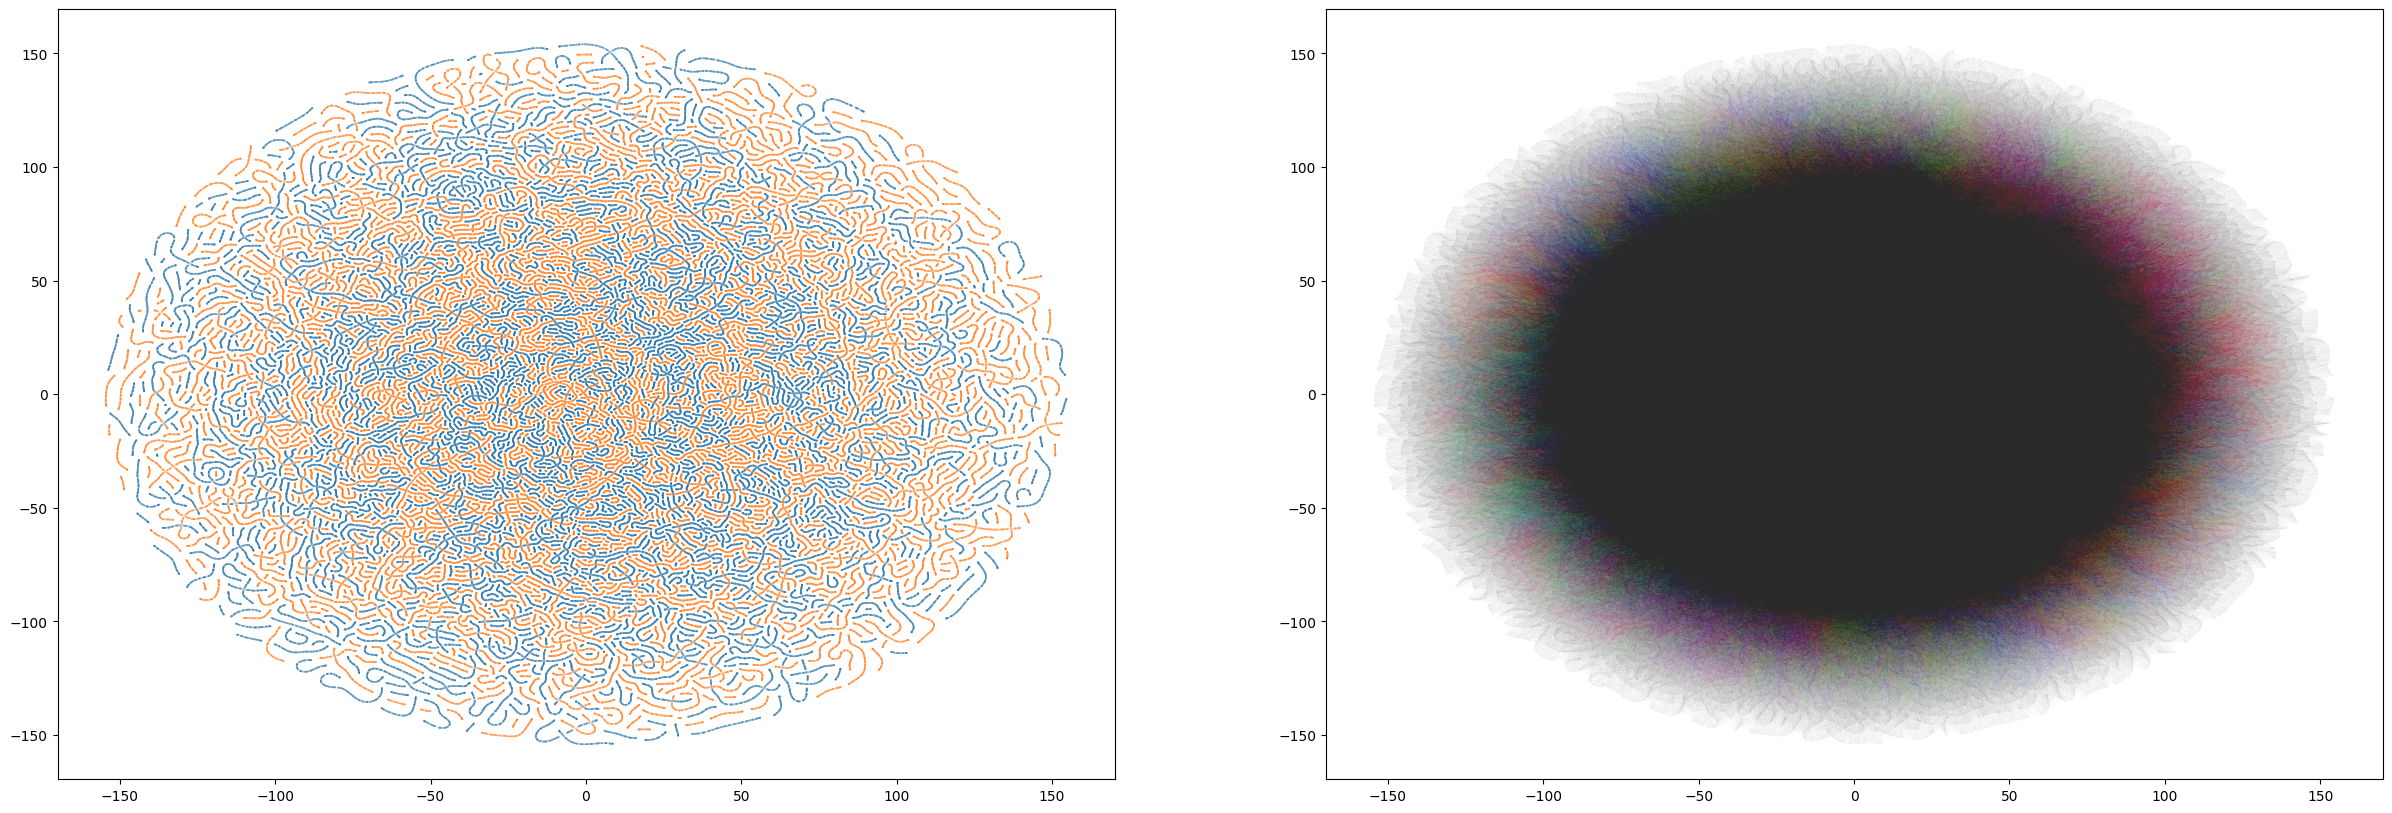

In [48]:
fig, (ax_left, ax_right) = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
tmp.plot.scatter(
    x="x",
    y="y",
    s=0.05,
    c="l",
    alpha=0.1,
    xlabel="",
    ylabel="",
    ax=ax_left)
tmp.plot.scatter(
    x="x",
    y="y",
    s=0.05,
    c="l",
    alpha=0.0,
    xlabel="",
    ylabel="",
    ax=ax_right)
for ix in range(tmp_count):
    xs = (tmp["x"].iloc[ix], tmp["x"].iloc[ix + tmp_count])
    ys = (tmp["y"].iloc[ix], tmp["y"].iloc[ix + tmp_count])
    ax_right.add_line(Line2D(
        xs,
        ys,
        alpha=0.05,
        lw=0.05,
        c=angle_color(xs, ys)))
plt.savefig("full_euclid.png", bbox_inches="tight")
plt.show()

In [20]:
# k * n log(n) = t
total_time = ((11 * 60.0) + 50 * 60) + 3
k = total_time / (total_c * np.log(total_c))
new_size = 10000
k * new_size * np.log(new_size)

36.40130951397645

In [21]:
tt_count = 5000
tt = x[list(range(tt_count)) + list(range(total_c, total_c + tt_count)), :]
tt_y = [
    "tab:blue" for _ in range(tt_count)
] + [
    "tab:orange" for _ in range(tt_count)
]
tt.shape

(10000, 768)

In [38]:
%%time

tt_embedded = TSNE(
    n_components=2,
    learning_rate="auto",
    init="random",
    perplexity=10,
    method="barnes_hut",
    random_state=42,
    metric=distance,
    n_jobs=-1).fit_transform(tt)

CPU times: user 7min 18s, sys: 3min 49s, total: 11min 7s
Wall time: 5min 26s


In [42]:
t_df = pd.DataFrame({"x": tt_embedded[:, 0], "y": tt_embedded[:, 1], "l": tt_y})
t_df.head()

,x,y,l
0,10.191279,-0.124288,tab:blue
1,10.661931,0.182515,tab:blue
2,9.596572,-0.141701,tab:blue
3,10.114553,-0.260212,tab:blue
4,9.118676,0.021121,tab:blue


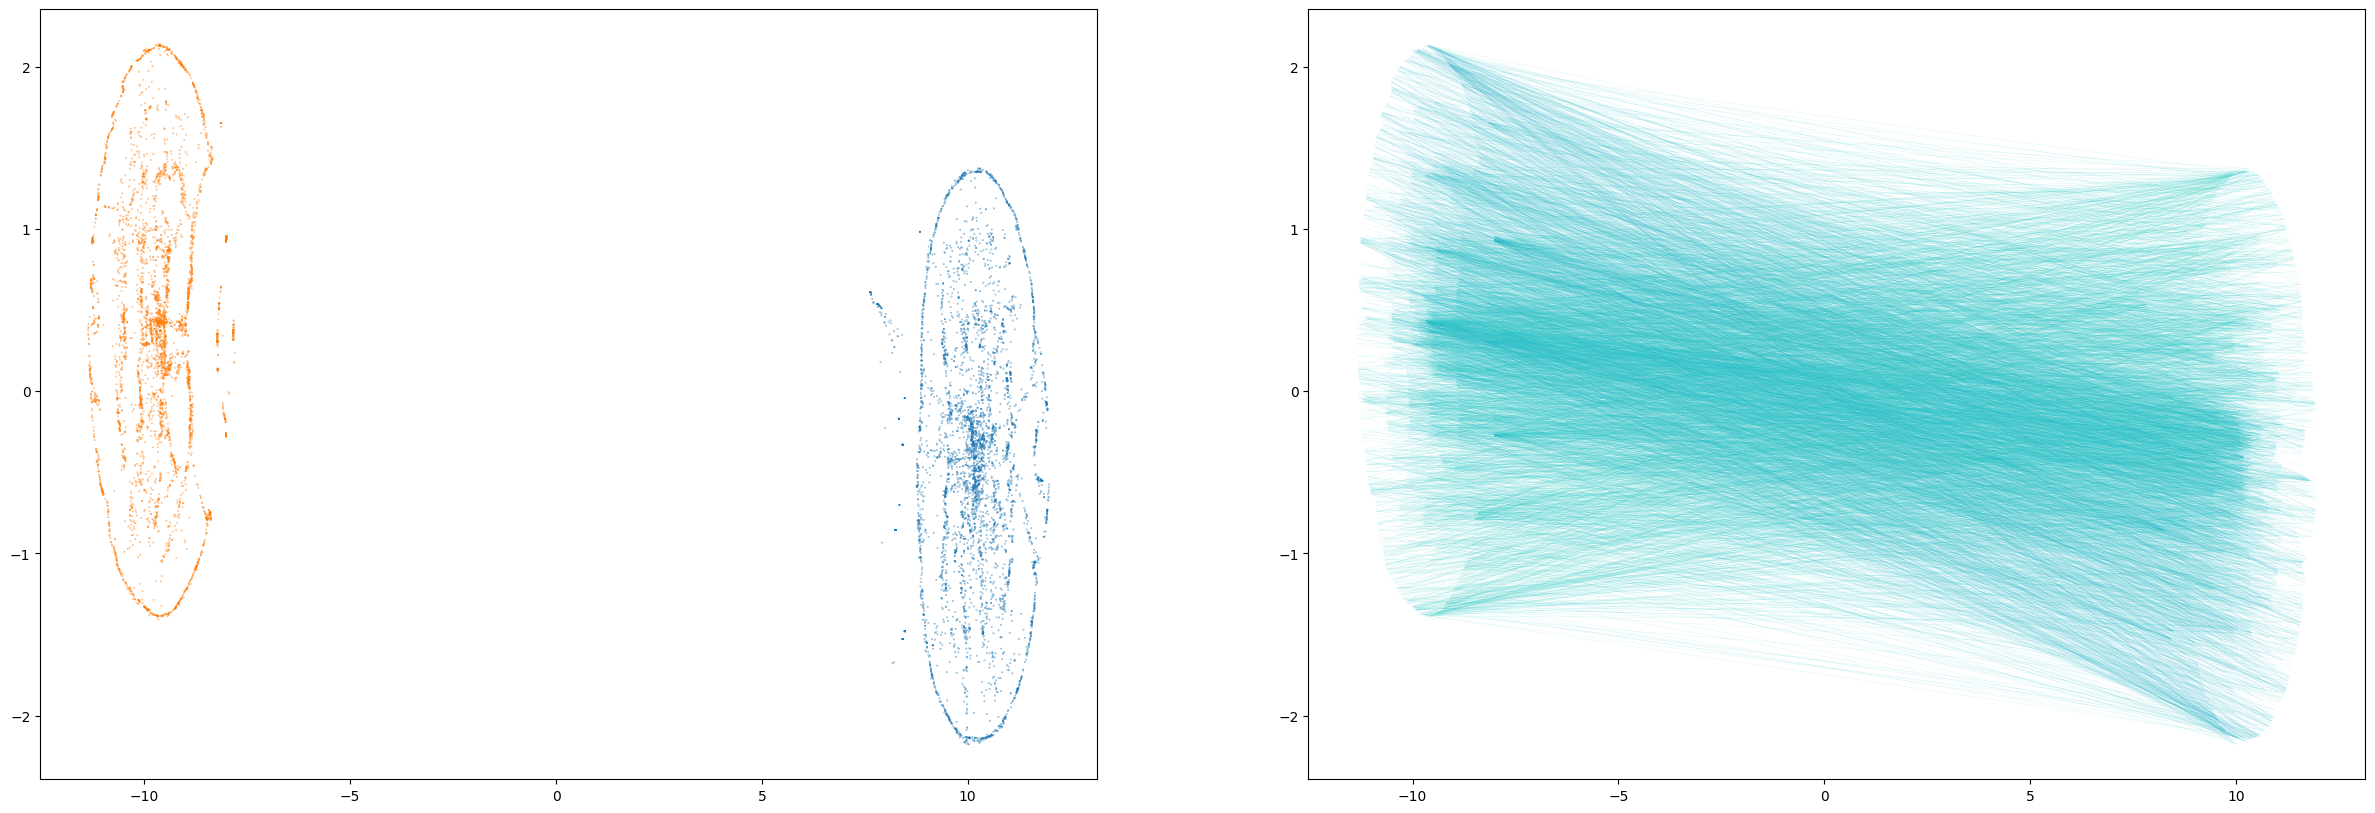

In [46]:
fig, (ax_left, ax_right) = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
t_df.plot.scatter(
    x="x",
    y="y",
    s=0.05,
    c="l",
    # alpha=0.1,
    xlabel="",
    ylabel="",
    ax=ax_left)
t_df.plot.scatter(
    x="x",
    y="y",
    s=0.05,
    c="l",
    alpha=0,
    xlabel="",
    ylabel="",
    ax=ax_right)
for ix in range(tt_count):
    xs = (t_df["x"].iloc[ix], t_df["x"].iloc[ix + tt_count])
    ys = (t_df["y"].iloc[ix], t_df["y"].iloc[ix + tt_count])
    ax_right.add_line(Line2D(
        xs,
        ys,
        # alpha=0.05,
        lw=0.05,
        c=angle_color(xs, ys)))
plt.savefig("subset_log1pexpneg.png", bbox_inches="tight")
plt.show()